In [2]:
# import libraries

# Data manipulation
import numpy as np
import pandas as pd
import datetime as dt

# Data visualisation
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.axes as ax

In [3]:
crm = pd.read_csv("crm.csv", index_col=0)
crm['purchase_time'] = crm['purchase_time'].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y %H:%M'))
crm.sort_values(by='purchase_time', ascending=False, inplace=True)

crm.head()

,contact_id,purchase_time,storeName
683974,583368,2019-06-26 23:30:00,Xin Wang Hong Kong Cafe
126813,145042,2019-06-26 23:22:00,Xin Wang Hong Kong Cafe
368690,214706,2019-06-26 23:15:00,Xin Wang Hong Kong Cafe
155145,11536,2019-06-26 22:57:00,NTUC Fairprice (CS)
487950,365479,2019-06-26 22:55:00,NTUC Fairprice (CS)


In [4]:
crm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750996 entries, 683974 to 690334
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   contact_id     750996 non-null  int64         
 1   purchase_time  750996 non-null  datetime64[ns]
 2   storeName      750996 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 22.9+ MB


In [5]:
crm.nunique()

contact_id        71533
purchase_time    134133
storeName           376
dtype: int64

## Time Series Analysis

In [6]:
crm['purchase_time'].describe()

# first half of 2019: 1 Jan to 26 June

<ipython-input-6-7127a9c859e9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                  750996
unique                 134133
top       2019-03-10 14:25:00
freq                       29
first     2019-01-01 00:14:00
last      2019-06-26 23:30:00
Name: purchase_time, dtype: object

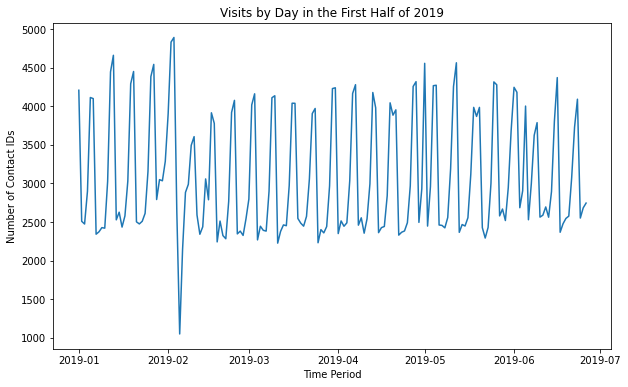

In [7]:
# number of unique contact_id visits throughout the time period
gb_time = crm[['contact_id','purchase_time']]
gb_time['day'] = gb_time['purchase_time'].apply(lambda x: x.date())
gb_spec_day= pd.DataFrame(gb_time.groupby('day')['contact_id'].nunique()).reset_index()

gb_spec_day.plot(x='day', y='contact_id', figsize=(10,6), legend=None)
plt.title("Visits by Day in the First Half of 2019")
plt.ylabel("Number of Contact IDs")
plt.xlabel("Time Period");

In [8]:
gb_spec_day.sort_values(by='contact_id', ascending=False)

,day,contact_id
33,2019-02-03,4892
32,2019-02-02,4832
12,2019-01-13,4661
131,2019-05-12,4564
120,2019-05-01,4557
...,...,...
48,2019-02-18,2243
83,2019-03-25,2232
69,2019-03-11,2227
36,2019-02-06,2147


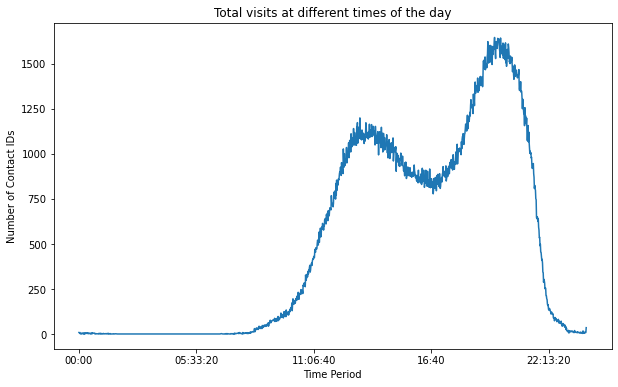

In [9]:
gb_time['time'] = gb_time['purchase_time'].apply(lambda x: x.time())
gb_spec_time = pd.DataFrame(gb_time.groupby('time')['contact_id'].nunique()).reset_index()

gb_spec_time.plot(x='time', y='contact_id', figsize=(10,6), legend=None)
plt.title("Total visits at different times of the day")
plt.ylabel("Number of Contact IDs")
plt.xlabel("Time Period");

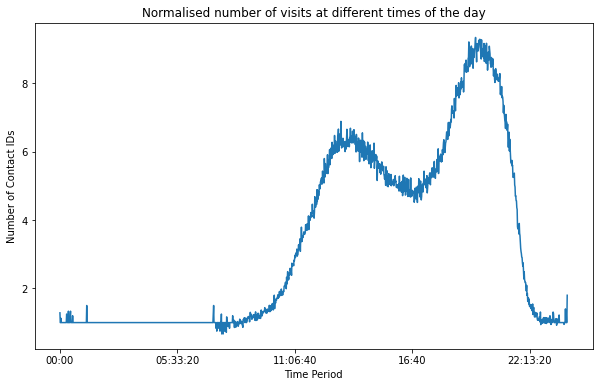

In [10]:
# num visits at timestamps normalised by number of days those visits happened  
num_days = gb_time.groupby('time')['day'].nunique()
num_visits = gb_time.groupby('time')['contact_id'].nunique()
gb_spec_time2 = pd.DataFrame(num_visits/num_days).reset_index().rename(columns={0:'contact_id'})

gb_spec_time2.plot(x='time', y='contact_id', figsize=(10,6), legend=None)
plt.title("Normalised number of visits at different times of the day")
plt.ylabel("Number of Contact IDs")
plt.xlabel("Time Period");

In [11]:
gb_spec_time2.sort_values(by='contact_id', ascending=False)

,time,contact_id
878,19:39:00,9.346591
890,19:51:00,9.295455
895,19:56:00,9.276836
887,19:48:00,9.265537
877,19:38:00,9.221591
...,...,...
144,07:25:00,0.750000
166,07:47:00,0.750000
171,07:52:00,0.714286
162,07:43:00,0.666667


### Observations:
- 1 customer visit (to the mall) defined as 1 unique Contact ID for that day
- Days: most visits on 3rd Feb, then 2nd Feb which is the weekend before Chinese New Year
- Days: least visits on 5th and 6th Feb, which are the first and second day of CNY respectively. Presumably, a lot of stores are closed on these two days

- Time: Peak hours are in the evening, especially around dinner time, about 7-8pm
- Time: Lowest visits in the morning and at the end of the day

## Analysis on Stores

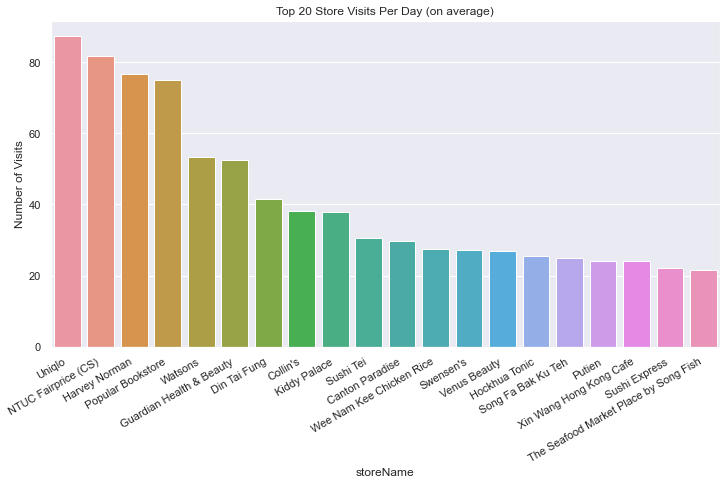

In [12]:
gb_stores = crm.groupby('storeName')['contact_id'].nunique().sort_values(ascending=False)
gb_stores /= (crm['purchase_time'].max() - crm['purchase_time'].min()).days + 1 # normalised by num days in data 
gb_stores = pd.DataFrame(gb_stores).reset_index().iloc[:20,:]

sns.set(rc={'figure.figsize':(12,6)})
ax = sns.barplot(x='storeName', y='contact_id', data=gb_stores)
ax.set_ylabel('Number of Visits')
ax.set_title('Top 20 Store Visits Per Day (on average)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right');

In [13]:
gb_stores_total = crm.groupby('storeName')['contact_id'].nunique().sort_values(ascending=False)
gb_stores_total = pd.DataFrame(gb_stores_total).reset_index()
gb_stores_total

,storeName,contact_id
0,Uniqlo,15459
1,NTUC Fairprice (CS),14461
2,Harvey Norman,13583
3,Popular Bookstore,13278
4,Watsons,9452
...,...,...
371,Xiao Yang Guo Kui,1
372,Sri Murugam Supermarket (Yishun 10),1
373,Snackz It,1
374,Phillip Investor Centre,1


### Observations: 
- Most frequently visited stores (overall and per day): Uniqlo, NTUC Fairprice (CS) and Harvey Norman
- Least frequently visited stores (overall and per day): Philip Investor Centre, Snackz It, Xiao Yang Guo Kui, etc.

In [14]:
def peak_period(store):
    """function to see trend of visits over the day for the store input in the argument"""
    crm_store = crm[crm['storeName'] == store]
    crm_store['day'] = crm_store['purchase_time'].apply(lambda x: x.date())
    crm_store['time'] = crm_store['purchase_time'].apply(lambda x: x.time())
    # normalise visits by days
    num_days = crm_store.groupby('time')['day'].nunique() # num days purchase happened at a certain time
    num_visits = crm_store.groupby('time')['contact_id'].nunique() # num visits happened at a certain time
    norm_visits = pd.DataFrame(num_visits/num_days).reset_index().rename(columns={0:'contact_id'})
    
    norm_visits.plot(x='time', y='contact_id', figsize=(10,6), legend=None)
    plt.title("Normalised number of visits at different times of the day for {}".format(store))
    plt.ylabel("Number of Visits")
    plt.xlabel("Time Period");
    
    peak = norm_visits.sort_values(by='contact_id', ascending=False).iloc[0]['time'].strftime('%H:%M')
    return "Peak period at around: {}".format(peak)

<ipython-input-14-f55bbf159fc3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-14-f55bbf159fc3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'Peak period at around: 11:40'

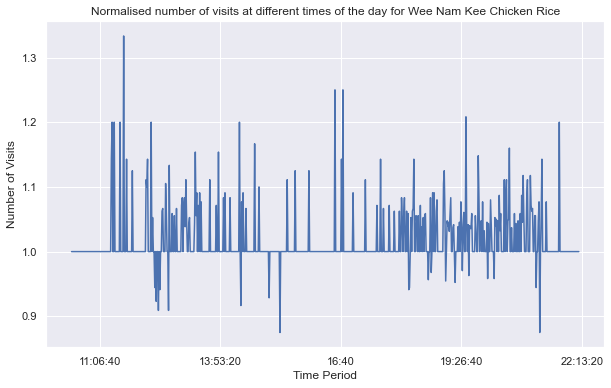

In [15]:
peak_period("Wee Nam Kee Chicken Rice")

## Recommender System
#### Using implicit ALS

In [16]:
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse # for csr matrices
import implicit # to use implicit ALS as recommendation model
import os # multithreading warning

In [17]:
crm1 = crm[['contact_id','storeName']]
crm1 = crm1.groupby(['contact_id','storeName']).size().reset_index().rename(columns={0:'frequency'})
crm1
# (427500, 3)

,contact_id,storeName,frequency
0,1002,Feng Food,1
1,1002,Krispy Kreme,1
2,1007,Takezo Ramen,1
3,1025,Canton Paradise,1
4,1025,Din Tai Fung,1
...,...,...,...
427495,644734,M1 by Arrow Communication,1
427496,644736,LeNu,1
427497,644736,Venus Beauty,1
427498,644737,NTUC Fairprice (CS),1


In [18]:
store_dict = {}
storenames = crm1['storeName'].unique()
for i in range(len(storenames)):
    store_dict[storenames[i]] = i
    
crm1['storeCode'] = crm1['storeName'].apply(lambda x: store_dict[x])
crm1

,contact_id,storeName,frequency,storeCode
0,1002,Feng Food,1,0
1,1002,Krispy Kreme,1,1
2,1007,Takezo Ramen,1,2
3,1025,Canton Paradise,1,3
4,1025,Din Tai Fung,1,4
...,...,...,...,...
427495,644734,M1 by Arrow Communication,1,219
427496,644736,LeNu,1,113
427497,644736,Venus Beauty,1,70
427498,644737,NTUC Fairprice (CS),1,53


In [19]:
# train, valid: 90,10% of unique CONTACT_IDs
train, valid = train_test_split(crm1, test_size=0.1, random_state=3101)

print('Train shape:', train.shape)
print('Val shape:', valid.shape)

Train shape: (384750, 4)
Val shape: (42750, 4)


In [20]:
# sparse matrices: store data with large number of zero-valued elements to save memory and speed up processing of that data
# sparse.csr_matrix(data, (row, col))
user_items = sparse.csr_matrix((train['frequency'].astype(float), (train['contact_id'], train['storeCode'])))
item_users = sparse.csr_matrix((train['frequency'].astype(float),(train['storeCode'], train['contact_id'])))

# format (row, col)  frequency, here we'll take frequency as confidence (customer's preference for that store)

In [21]:
os.environ['MKL_NUM_THREADS'] = '1' # to avoid multithreading
os.environ['OPENBLAS_NUM_THREADS'] = '1'

imp_model = implicit.als.AlternatingLeastSquares(factors=100, iterations=10)

In [22]:
# what is alpha for??
# alpha = 40
# train_conf = (item_users*alpha).astype('double')

In [23]:
imp_model.fit(item_users)

  0%|          | 0/10 [00:00<?, ?it/s]

### Evaluation: MAP@k for validation set

In [24]:
# actual visit history (to compare with predictions)
contacts_actual = crm1.groupby('contact_id').agg({
    'storeCode':lambda x: list(set(x))
}).reset_index()

contacts_actual

,contact_id,storeCode
0,1002,"[0, 1]"
1,1007,[2]
2,1025,"[3, 4, 5, 6, 7]"
3,1028,"[3, 5]"
4,1034,[8]
...,...,...
71528,644733,[81]
71529,644734,[219]
71530,644736,"[113, 70]"
71531,644737,[53]


In [25]:
def ap_at_k(contact, k=10):
    """
    Computes the average precision at k between actual and predicted list of stores visited.
    Parameters
    ----------
    contact (int) : contact_id for which we are predicting stores visited
    k (int, optional) : maximum number of predicted elements
    Returns
    -------
    score (float) : average precision at k over the actual and predicted stores visited
    """
    precision_sum = 0.0
    relevant_count = 0.0 
    # list of elements that are to be predicted (order doesn't matter)
    actual = contacts_actual[contacts_actual['contact_id'] == contact]['storeCode'].iloc[0]
    # list of predicted (storeid, score) tuples (order matters)
    predicted = imp_model.recommend(contact, user_items, N=k)
    
    for i,store in enumerate(predicted):
        storeid, score = store
        if storeid in actual:
            relevant_count += 1.0
            precision_sum +=  relevant_count/(i+1.0)
            
    if relevant_count == 0: # division by zero
        return 0.0    
    return precision_sum/relevant_count

In [26]:
contacts = valid['contact_id'].values.tolist()
scores = 0.0
for c in contacts:
    scores += ap_at_k(c)
    
print('MAP@k for validation set: {0:.3f}'.format(scores/len(contacts)))

MAP@k for validation set: 0.038


#### Additional functions of the ALS model:
- similar items (stores)
- similar users

In [27]:
imp_model.similar_items(4, N=5) # store 4: Din Tai Fung

[(4, 1.0),
 (372, 0.2253452),
 (240, 0.15914685),
 (49, 0.15611887),
 (355, 0.14693913)]

In [28]:
imp_model.similar_users(1179, N=5)

[(1179, 1.0000001),
 (379835, 0.74481726),
 (587957, 0.69596815),
 (586154, 0.67077565),
 (339114, 0.66747487)]

## Recommender System
#### Using PySpark Recommender System (ALS)

In [29]:
crm2 = crm1[['contact_id','storeCode']].drop_duplicates()
crm2['Ones'] = 1
crm2 = crm2.groupby(['contact_id', 'storeCode'])['Ones'].sum().unstack().fillna(0)
crm2

storeCode,0,1,2,3,4,5,6,7,8,9,...,366,367,368,369,370,371,372,373,374,375
contact_id,,,,,,,,,,,,,,,,,,,,,
1002,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1025,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1028,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
644734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
644736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
crm2 = pd.DataFrame(crm2.stack()).reset_index().rename(columns={0:'binary'})
crm2

,contact_id,storeCode,binary
0,1002,0,1.0
1,1002,1,1.0
2,1002,2,0.0
3,1002,3,0.0
4,1002,4,0.0
...,...,...,...
26896403,644741,371,0.0
26896404,644741,372,0.0
26896405,644741,373,0.0
26896406,644741,374,0.0


In [31]:
# purge contact_id, at least 5 store visits
contacts_freq = crm2.groupby('contact_id')['binary'].sum() > 4
crm2 = crm2[crm2['contact_id'].isin(crm2['contact_id'].unique()[contacts_freq])]
crm2

,contact_id,storeCode,binary
752,1025,0,0.0
753,1025,1,0.0
754,1025,2,0.0
755,1025,3,1.0
756,1025,4,1.0
...,...,...,...
26890387,644697,371,0.0
26890388,644697,372,0.0
26890389,644697,373,0.0
26890390,644697,374,0.0


In [32]:
# purge storeCode, at least 50 store visits
store_freq = crm2.groupby('storeCode')['binary'].sum() > 49
crm2 = crm2[crm2['storeCode'].isin(crm2['storeCode'].unique()[store_freq])]
crm2

,contact_id,storeCode,binary
752,1025,0,0.0
753,1025,1,0.0
754,1025,2,0.0
755,1025,3,1.0
756,1025,4,1.0
...,...,...,...
26890361,644697,345,0.0
26890362,644697,346,0.0
26890365,644697,349,0.0
26890366,644697,350,0.0


In [33]:
crm2 = crm2[crm2['binary'] == 1.0]
crm2

,contact_id,storeCode,binary
755,1025,3,1.0
756,1025,4,1.0
757,1025,5,1.0
758,1025,6,1.0
759,1025,7,1.0
...,...,...,...
26890027,644697,11,1.0
26890029,644697,13,1.0
26890051,644697,35,1.0
26890099,644697,83,1.0


In [34]:
crm2.to_csv('crm2.csv')

In [35]:
from pyspark.sql.functions import col, explode
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [36]:
sc = SparkContext
# sc.setCheckpointDir('checkpoint')
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

Exception: Java gateway process exited before sending its port number

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
(train, valid) = crm2.randomSplit([0.8, 0.2], seed = 3101)

# ALS model
als = ALS(userCol="contact_id", 
          itemCol="storeCode", 
          ratingCol="binary", 
          implicitPrefs = True, 
          coldStartStrategy="drop") # so we don't get NaN eval metrics

# Confirm that a model called "als" was created
type(als)